In [56]:
import os, glob

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from keras.utils import to_categorical
from skimage.io import imread, imshow, imsave
from keras import backend as K
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger
from collections import namedtuple

In [57]:
# used functions from CodaLab competition https://codalab.coresearch.club/competitions/51

def getData(num_tests, start, type):
    
    # path on local machine
    searchAnnotated = os.path.join("..", "y_train", "*", "*labelTrainIds*")
    searchRaw = os.path.join("..", "x_train", "*", "*")

    filesAnnotated = glob.glob(searchAnnotated)

    filesRaw = glob.glob(searchRaw)
    filesAnnotated.sort()
    filesRaw.sort()

    return filesAnnotated[start:start+num_tests], filesRaw[start:start+num_tests]


def UpscaleImg(img,scale, dims):
    if dims:
        new_img = np.zeros((img.shape[0]*scale,img.shape[1]*scale,3))
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                new_img[i*scale:(i+1)*scale,j*scale:(j+1)*scale,:]=img[i,j,:]
    else:
        new_img = np.zeros((img.shape[0] * scale, img.shape[1] * scale))
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                new_img[i * scale:(i + 1) * scale, j * scale:(j + 1) * scale] = img[i, j]
    return new_img


def importBatch(num_tests, start, verbose, type="train", scale = 0):   #load batch of data from train dataset

    y_files, X_files = getData(num_tests,start, type)
    X_input = []
    y_input = []
    if type=='val':
        filenames = []
    z = 0
    for i in range(len(X_files)):

        z+=1
        if verbose:
            if z % 100 == 0:
                print('loaded files input - ', z)

        X_file = X_files[i]
        filenames.append(X_file[:-16])
        X_img = imread(X_file)

        if (scale != 0):
            X_new = np.zeros((int(X_img.shape[0] / scale), int(X_img.shape[1] / scale),3))
            k = 0
            for x in X_img[::scale]:
                X_new[k]=x[::scale]
                k+=1
                X_img = X_new
        X_input.append(X_img)
    z = 0
    for i in range(len(y_files)):
        z += 1
        if verbose:
            if z % 100 == 0:
                print('loaded files output - ', z)

        y_file = y_files[i]
        y_img = imread(y_file)
        if (scale != 0):
            y_new = np.zeros((int(y_img.shape[0] / scale), int(y_img.shape[1] / scale)))
            k = 0
            for y in y_img[::scale]:
                y_new[k] = y[::scale]
                k += 1
                y_img = y_new
        y_input.append(y_img)

    X = np.array(X_input)
    y = np.array(y_input)
    if (type=='val'):
        return X,y, filenames
    return X, y


def keras_generator(batch_size,scale):
    while True:
        batch_nums = np.random.randint(low=100, high=2700, size=batch_size)
        batch_input = []
        batch_output = []
        
        for index in batch_nums:
            input_labels, input_images = getData(1, index,type='train')
            input_image = input_images[0]
            input_label = input_labels[0]           
            
            X_img = imread(input_image)
            if (scale != 0):
                X_new = np.zeros((int(X_img.shape[0] / scale), int(X_img.shape[1] / scale),3))
                k = 0
                for x in X_img[::scale]:
                    X_new[k]=x[::scale]
                    k+=1
                X_img = X_new
            y_img = imread(input_label)
            if (scale != 0):
                y_new = np.zeros((int(y_img.shape[0] / scale), int(y_img.shape[1] / scale)))
                k = 0
                for y in y_img[::scale]:
                    y_new[k] = y[::scale]
                    k += 1
                y_img = y_new
            
            y_img[y_img==255] = 19
            y_img = to_categorical(y_img)
            
            batch_input.append(X_img)
            batch_output.append(y_img)
            
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)        
        yield batch_x, batch_y

In [58]:
def iou_loss_core(true,pred):
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5

    ones = K.ones(K.shape(y_true))
    p0 = y_pred 
    p1 = ones - y_pred
    g0 = y_true
    g1 = ones - y_true

    num = K.sum(p0 * g0, (0, 1, 2))
    den = num + alpha * K.sum(p0 * g1, (0, 1, 2)) + beta * K.sum(p1 * g0, (0, 1, 2)) + 1e-8

    T = K.sum(num / den)

    classNumber = K.cast(K.shape(y_true)[-1], 'float32') ### equal classNumber = 20.0
    return classNumber - T

In [60]:
# load validation sample

x_val, y_val, files = importBatch(50,50,0,'val',scale = 2)
y_val[y_val==255] = 19
y_val = to_categorical(y_val)

x_val_4, y_val_4, _ = importBatch(50,50,0,'val',scale = 4)
y_val_4[y_val_4==255] = 19
y_val_4 = to_categorical(y_val_4)

In [66]:
# models, mentioned in text

resnet = keras.models.load_model('models/02-simple-resnet-tver.hdf5', custom_objects={'tversky_loss': tversky_loss, 'iou_loss_core': iou_loss_core})
fpn_1 = keras.models.load_model('models/05-fpn-1.hdf5', custom_objects={'tversky_loss': tversky_loss, 'iou_loss_core': iou_loss_core})
fpn_2 = keras.models.load_model('models/07-fpn-triangle-120.hdf5', custom_objects={'tversky_loss': tversky_loss, 'iou_loss_core': iou_loss_core})
fpn_3 = keras.models.load_model('models/09-other-fpn.hdf5', custom_objects={'tversky_loss': tversky_loss, 'iou_loss_core': iou_loss_core})
pspnet_1 = keras.models.load_model('models/10-pspnet.hdf5', custom_objects={'tversky_loss': tversky_loss, 'iou_loss_core': iou_loss_core})
pspnet_2 = keras.models.load_model('models/11-pspnet-2.hdf5', custom_objects={'tversky_loss': tversky_loss, 'iou_loss_core': iou_loss_core})
pspnet_2_2x = keras.models.load_model('models/13-2x-pspnet-50.hdf5', custom_objects={'tversky_loss': tversky_loss, 'iou_loss_core': iou_loss_core})
pspnet_3_2x = keras.models.load_model('models/17-mod-pspnet-75.hdf5', custom_objects={'tversky_loss': tversky_loss, 'iou_loss_core': iou_loss_core})
resnet_pspnet = keras.models.load_model('models/18-pspnet-with-resnet.hdf5', custom_objects={'tversky_loss': tversky_loss, 'iou_loss_core': iou_loss_core})


In [73]:
def compile_model(model):
    model.compile(optimizer = Adam(lr = 0.0001), loss = tversky_loss, metrics = ['accuracy', iou_loss_core])

In [74]:
for m in [resnet, fpn_1, fpn_2, fpn_3, pspnet_1, pspnet_2, pspnet_2_2x, pspnet_3_2x, resnet_pspnet]:
    compile_model(m)

In [75]:
# model train examples

generator = keras_generator(1,  2)
csv_logger = CSVLogger('log.csv', append=True, separator=';')
checkpoint = ModelCheckpoint('data/nn1.h5', monitor='loss', verbose=1, save_best_only=True)
pspnet_3_2x.fit_generator(generator, steps_per_epoch=2000, epochs=50, callbacks=[checkpoint, csv_logger], validation_data=(x_val, y_val), validation_steps=20)


Epoch 1/50
  35/2000 [..............................] - ETA: 30:27 - loss: 11.7603 - acc: 0.8470 - iou_loss_core: 0.8449

KeyboardInterrupt: 

In [76]:
#resnet

generator = keras_generator(1,  4)
csv_logger = CSVLogger('log.csv', append=True, separator=';')
checkpoint = ModelCheckpoint('data/nn1.h5', monitor='loss', verbose=1, save_best_only=True)
resnet.fit_generator(generator, steps_per_epoch=2000, epochs=100, callbacks=[checkpoint, csv_logger], validation_data=(x_val_4, y_val_4), validation_steps=20)


Epoch 1/100
  32/2000 [..............................] - ETA: 18:36 - loss: 12.9030 - acc: 0.8417 - iou_loss_core: 0.8405

KeyboardInterrupt: 

In [77]:
#fpn_v1

generator = keras_generator(1,  4)
csv_logger = CSVLogger('log.csv', append=True, separator=';')
checkpoint = ModelCheckpoint('data/nn1.h5', monitor='loss', verbose=1, save_best_only=True)
fpn_1.fit_generator(generator, steps_per_epoch=2000, epochs=100, callbacks=[checkpoint, csv_logger], validation_data=(x_val_4, y_val_4), validation_steps=20)


Epoch 1/100
  13/2000 [..............................] - ETA: 43:28 - loss: 12.8598 - acc: 0.7729 - iou_loss_core: 0.7664

KeyboardInterrupt: 

In [78]:
#fpn_v2

generator = keras_generator(1,  4)
csv_logger = CSVLogger('log.csv', append=True, separator=';')
checkpoint = ModelCheckpoint('data/nn1.h5', monitor='loss', verbose=1, save_best_only=True)
fpn_2.fit_generator(generator, steps_per_epoch=2000, epochs=100, callbacks=[checkpoint, csv_logger], validation_data=(x_val_4, y_val_4), validation_steps=20)


Epoch 1/100
  16/2000 [..............................] - ETA: 34:09 - loss: 12.8411 - acc: 0.7706 - iou_loss_core: 0.7690

KeyboardInterrupt: 

In [79]:
#fpn_v3

generator = keras_generator(1,  4)
csv_logger = CSVLogger('log.csv', append=True, separator=';')
checkpoint = ModelCheckpoint('data/nn1.h5', monitor='loss', verbose=1, save_best_only=True)
fpn_3.fit_generator(generator, steps_per_epoch=2000, epochs=100, callbacks=[checkpoint, csv_logger], validation_data=(x_val_4, y_val_4), validation_steps=20)


Epoch 1/100
  24/2000 [..............................] - ETA: 25:07 - loss: 13.1403 - acc: 0.7916 - iou_loss_core: 0.7892

KeyboardInterrupt: 

In [81]:
#pspnet_v1

generator = keras_generator(1,  4)
csv_logger = CSVLogger('log.csv', append=True, separator=';')
checkpoint = ModelCheckpoint('data/nn1.h5', monitor='loss', verbose=1, save_best_only=True)
pspnet_1.fit_generator(generator, steps_per_epoch=2000, epochs=100, callbacks=[checkpoint, csv_logger], validation_data=(x_val_4, y_val_4), validation_steps=20)


Epoch 1/100
  47/2000 [..............................] - ETA: 16:48 - loss: 12.1422 - acc: 0.8357 - iou_loss_core: 0.8350

KeyboardInterrupt: 

In [82]:
#pspnet_v2

generator = keras_generator(1,  4)
csv_logger = CSVLogger('log.csv', append=True, separator=';')
checkpoint = ModelCheckpoint('data/nn1.h5', monitor='loss', verbose=1, save_best_only=True)
pspnet_2.fit_generator(generator, steps_per_epoch=2000, epochs=100, callbacks=[checkpoint, csv_logger], validation_data=(x_val_4, y_val_4), validation_steps=20)


Epoch 1/100
  18/2000 [..............................] - ETA: 30:35 - loss: 12.1411 - acc: 0.8354 - iou_loss_core: 0.8343

KeyboardInterrupt: 

In [83]:
#pspnet_v2_2x

generator = keras_generator(1,  2)
csv_logger = CSVLogger('log.csv', append=True, separator=';')
checkpoint = ModelCheckpoint('data/nn1.h5', monitor='loss', verbose=1, save_best_only=True)
pspnet_2_2x.fit_generator(generator, steps_per_epoch=2000, epochs=50, callbacks=[checkpoint, csv_logger], validation_data=(x_val, y_val), validation_steps=20)


Epoch 1/50
   5/2000 [..............................] - ETA: 3:00:17 - loss: 12.5968 - acc: 0.8198 - iou_loss_core: 0.8181

KeyboardInterrupt: 

In [84]:
#resnet

generator = keras_generator(1,  4)
csv_logger = CSVLogger('log.csv', append=True, separator=';')
checkpoint = ModelCheckpoint('data/nn1.h5', monitor='loss', verbose=1, save_best_only=True)
resnet.fit_generator(generator, steps_per_epoch=2000, epochs=100, callbacks=[checkpoint, csv_logger], validation_data=(x_val_4, y_val_4), validation_steps=20)


Epoch 1/100
  34/2000 [..............................] - ETA: 5:03 - loss: 12.7954 - acc: 0.8352 - iou_loss_core: 0.8339

KeyboardInterrupt: 

In [85]:
#resnet+pspnet

generator = keras_generator(1,  4)
csv_logger = CSVLogger('log.csv', append=True, separator=';')
checkpoint = ModelCheckpoint('data/nn1.h5', monitor='loss', verbose=1, save_best_only=True)
resnet_pspnet.fit_generator(generator, steps_per_epoch=2000, epochs=100, callbacks=[checkpoint, csv_logger], validation_data=(x_val_4, y_val_4), validation_steps=20)


Epoch 1/100
  17/2000 [..............................] - ETA: 36:48 - loss: 11.4505 - acc: 0.8741 - iou_loss_core: 0.8738

KeyboardInterrupt: 

In [87]:
fpn_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
average_pooling2d_35 (AveragePo (None, 128, 256, 3)  0           input_19[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_36 (AveragePo (None, 64, 128, 3)   0           average_pooling2d_35[0][0]       
__________________________________________________________________________________________________
average_pooling2d_37 (AveragePo (None, 32, 64, 3)    0           average_pooling2d_36[0][0]       
__________________________________________________________________________________________________
average_po

In [88]:
fpn_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
average_pooling2d_83 (AveragePo (None, 128, 256, 3)  0           input_36[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_84 (AveragePo (None, 64, 128, 3)   0           average_pooling2d_83[0][0]       
__________________________________________________________________________________________________
average_pooling2d_85 (AveragePo (None, 32, 64, 3)    0           average_pooling2d_84[0][0]       
__________________________________________________________________________________________________
average_po

In [89]:
fpn_3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
average_pooling2d_103 (AverageP (None, 128, 256, 3)  0           input_40[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_104 (AverageP (None, 64, 128, 3)   0           average_pooling2d_103[0][0]      
__________________________________________________________________________________________________
average_pooling2d_105 (AverageP (None, 32, 64, 3)    0           average_pooling2d_104[0][0]      
__________________________________________________________________________________________________
average_po

In [90]:
pspnet_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_529 (Conv2D)             (None, 256, 512, 8)  224         input_43[0][0]                   
__________________________________________________________________________________________________
conv2d_530 (Conv2D)             (None, 256, 512, 16) 1168        conv2d_529[0][0]                 
__________________________________________________________________________________________________
conv2d_531 (Conv2D)             (None, 256, 512, 32) 4640        conv2d_530[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [91]:
pspnet_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_539 (Conv2D)             (None, 256, 512, 8)  224         input_44[0][0]                   
__________________________________________________________________________________________________
conv2d_540 (Conv2D)             (None, 256, 512, 24) 1752        conv2d_539[0][0]                 
__________________________________________________________________________________________________
conv2d_541 (Conv2D)             (None, 256, 512, 64) 13888       conv2d_540[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [92]:
pspnet_2_2x.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 512, 1024, 3) 0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 512, 1024, 8) 224         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 512, 1024, 24 1752        conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 512, 1024, 42 9114        conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv2d_24 

In [93]:
pspnet_3_2x.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 512, 1024, 3) 0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 512, 1024, 8) 224         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 512, 1024, 24 1752        conv2d_52[0][0]                  
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 512, 1024, 64 13888       conv2d_53[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [94]:
resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 256, 512, 8)  224         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 256, 512, 8)  584         conv2d_47[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 256, 8)  0           conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_49 

In [95]:
resnet_pspnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 256, 512, 8)  224         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 256, 512, 8)  584         conv2d_47[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 256, 8)  0           conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_49 

In [32]:
# got from CityScapes github https://github.com/mcordts/cityscapesScripts/tree/master/cityscapesscripts

Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
] )

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [36]:
colormap = {}
for i in range(-1,34):
    colormap[labels[i].trainId] = np.flip(np.array(labels[i].color), 0)
colormap[19] = np.array([0, 0, 0])

def paint(pred, colormap):
    new_arr = np.ndarray((pred.shape[0], pred.shape[1], 3))
    for i in range(pred.shape[0]):
        for j in range(pred.shape[1]):
            new_arr[i,j,:] = colormap[int(pred[i][j])]
            
    return new_arr

def do_predict(model, X, scale, num=-1):
    if num==-1:
        pred = model.predict(X, verbose=0)
    else:
        pred = model.predict(X[num:num+1], verbose=0)
    pred = np.argmax(pred,axis=3).astype(int)
    final_pred = np.ndarray((pred.shape[0], pred.shape[1] * scale, pred.shape[2] * scale))
    for i in range(pred.shape[0]):
        final_pred[i] = UpscaleImg(pred[i], scale, False)
    return final_pred

In [34]:
x_val_full, y_val_full, files = importBatch(50,50,0,'val',scale = 1)
y_val_full[y_val_full==255] = 19

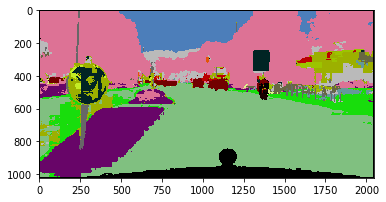

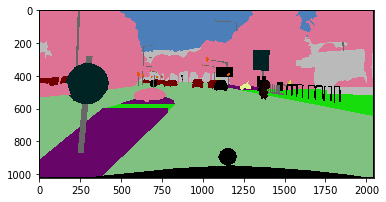

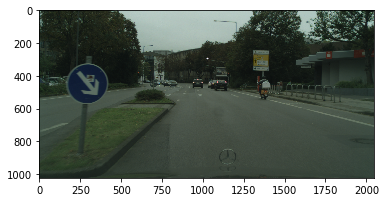

In [42]:
# prediction examples

NUM = 3
pred = do_predict(pspnet_3_2x, x_val, 2, NUM)
plt.imshow(paint(pred[0], colormap))
plt.show()
plt.imshow(paint(y_val_full[NUM],colormap))
plt.show()
plt.imshow(imread(files[NUM]+'_leftImg8bit.png'))
plt.show()

In [98]:
# pspnet_3_2x keras implementation

inp = Input((512, 1024, 3))
first_conv_1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(inp)
first_conv_2 = Conv2D(filters=24, kernel_size=(3, 3), activation='relu', padding='same')(first_conv_1)
img_512 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(first_conv_2)
img_256 = MaxPooling2D((2, 2))(img_512)
img_128 = MaxPooling2D((2, 2))(img_256)
img_64 = MaxPooling2D((2, 2))(img_128)
img_32 = MaxPooling2D((2, 2))(img_64)
img_16 = MaxPooling2D((2, 2))(img_32)

conv_16_1 = Conv2D(filters=24, kernel_size=(3, 3), activation='relu', padding='same')(img_16)
conv_16_2 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(conv_16_1)
conv_16_3 = Conv2D(filters=48, kernel_size=(3, 3), activation='relu', padding='same')(conv_16_2)

conv_32_1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(img_32)
conv_32_2 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(conv_32_1)

conv_64_1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(img_64)

conv_128_1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(img_128)

conv_256_1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(img_256)

conv_512_1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(img_512)

up_32 = UpSampling2D()(conv_16_3)
conc_32 = concatenate([up_32, conv_32_2], axis=3)

up_64 = UpSampling2D()(conc_32)
conc_64 = concatenate([up_64, conv_64_1], axis=3)

up_128 = UpSampling2D()(conc_64)
conc_128 = concatenate([up_128, conv_128_1], axis=3)

up_256 = UpSampling2D()(conc_128)
conc_256 = concatenate([up_256, conv_256_1], axis=3)

up_512 = UpSampling2D()(conc_256)
conc_512 = concatenate([up_512, conv_512_1], axis=3)

conv_final_1 = Conv2D(filters=96, kernel_size=(3, 3), activation='relu', padding='same')(conc_512)
conv_final_2 = Conv2D(filters=20, kernel_size=(1, 1), activation='softmax', padding='same')(conv_final_1)

model_1 = keras.models.Model(input=inp, output=conv_final_2)

model_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 512, 1024, 3) 0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 512, 1024, 8) 224         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 512, 1024, 24 1752        conv2d_204[0][0]                 
__________________________________________________________________________________________________
conv2d_206 (Conv2D)             (None, 512, 1024, 64 13888       conv2d_205[0][0]                 
__________________________________________________________________________________________________
max_poolin

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [96]:
#FPN_v3

img_256 = Input((256, 512, 3))
img_128 = AveragePooling2D((2, 2))(img_256)
img_64 = AveragePooling2D((2, 2))(img_128)
img_32 = AveragePooling2D((2, 2))(img_64)
img_16 = AveragePooling2D((2, 2))(img_32)
img_8 = AveragePooling2D((2, 2))(img_16)

conv_16_1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(img_16)
conv_16_2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(conv_16_1)
conv_16_3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(conv_16_2)
conv_16_4 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(conv_16_3)

conv_32_1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(img_32)
conv_32_2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(conv_32_1)
conv_32_3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(conv_32_2)

conv_64_1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(img_64)
conv_64_2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(conv_64_1)
conv_64_3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(conv_64_2)

conv_128_1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(img_128)
conv_128_2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(conv_128_1)
conv_128_3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(conv_128_2)
                                                                                      
conv_256_1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(img_256)
conv_256_2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(conv_256_1)

up_32 = UpSampling2D()(conv_16_4)
conc_32 = concatenate([up_32, conv_32_3], axis=3)

up_64 = UpSampling2D()(conc_32)
conc_64 = concatenate([up_64, conv_64_3], axis=3)

up_128 = UpSampling2D()(conc_64)
conc_128 = concatenate([up_128, conv_128_3], axis=3)

up_256 = UpSampling2D()(conc_128)
conc_256 = concatenate([up_256, conv_256_2], axis=3)

conv_final_1 = Conv2D(filters=96, kernel_size=(2, 2), activation='relu', padding='same')(conc_256)
conv_final_2 = Conv2D(filters=48, kernel_size=(2, 2), activation='relu', padding='same')(conv_final_1)
conv_final_3 = Conv2D(filters=20, kernel_size=(1, 1), activation='softmax', padding='same')(conv_final_2)

model_2 = keras.models.Model(input=img_256, output=conv_final_3)

model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
average_pooling2d_16 (AveragePo (None, 128, 256, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_17 (AveragePo (None, 64, 128, 3)   0           average_pooling2d_16[0][0]       
__________________________________________________________________________________________________
average_pooling2d_18 (AveragePo (None, 32, 64, 3)    0           average_pooling2d_17[0][0]       
__________________________________________________________________________________________________
average_po

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [97]:
img_256 = resnet.layers[-2].output
img_128 = MaxPooling2D((2, 2))(img_256)
img_64 = MaxPooling2D((2, 2))(img_128)
img_32 = MaxPooling2D((2, 2))(img_64)
img_16 = MaxPooling2D((2, 2))(img_32)

conv_16_1 = Conv2D(filters=24, kernel_size=(3, 3), activation='relu', padding='same')(img_16)
conv_16_2 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(conv_16_1)
conv_16_3 = Conv2D(filters=48, kernel_size=(3, 3), activation='relu', padding='same')(conv_16_2)

conv_32_1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(img_32)
conv_32_2 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(conv_32_1)

conv_64_1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(img_64)

conv_128_1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(img_128)

conv_256_1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(img_256)

up_32 = UpSampling2D()(conv_16_3)
conc_32 = concatenate([up_32, conv_32_2], axis=3)

up_64 = UpSampling2D()(conc_32)
conc_64 = concatenate([up_64, conv_64_1], axis=3)

up_128 = UpSampling2D()(conc_64)
conc_128 = concatenate([up_128, conv_128_1], axis=3)

up_256 = UpSampling2D()(conc_128)
conc_256 = concatenate([up_256, conv_256_1], axis=3)

conv_final_1 = Conv2D(filters=96, kernel_size=(3, 3), activation='relu', padding='same')(conc_256)
conv_final_2 = Conv2D(filters=20, kernel_size=(1, 1), activation='softmax', padding='same')(conv_final_1)

model_3 = keras.models.Model(input=resnet.input, output=conv_final_2)

model_3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 256, 512, 8)  224         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 256, 512, 8)  584         conv2d_47[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 256, 8)  0           conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_49 

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
